# Predicting wine quality given chemical characteristics of the wine
by Yixuan Gao, Bryan Lee, Wangkai Zhu, Timothy Singh

## Summary

This project aims to build a machine learning model to classify the quality of red wine based on its physicochemical properties. The target variable, wine quality, is scored on a scale from 0 (poor quality) to 10 (high quality), presenting a multi-class classification challenge. The dataset, sourced from the UC Irvine Machine Learning Repository, comprises 1,599 observations with 11 continuous features such as acidity, alcohol content, and citric acid.

Four classification algorithms were evaluated: Logistic Regression, Decision Tree, K-Nearest Neighbors (KNN), Naive Bayes and Support Vector Machine with a Radial Basis Function kernel (SVM RBF). 5-fold cross-validation was used with training data to find the best classification algorithm, based on accuracy. Hyperparameter tuning was used to optimize the model and assess its generalization performance. The model with hyperparameters that gave the best accuracy was selected for deployment on the test set.

By leveraging machine learning, this project seeks to provide a systematic and measurable way to predict wine quality, aiding manufacturers and suppliers in assessing product value based on its chemical properties.

## Introduction:


Red wine has been a cultural and economic staple since ancient times, originating from early civilizations like the Greeks and evolving into a global industry valued at approximately 109.5 billion USD. Despite its widespread availability, differentiating between high and low-quality wines remains a challenge for most consumers. Traditionally, this task has relied on the expertise of sommeliers, whose judgments are often subjective.

This project aims to bridge the gap between subjective assessments and objective measurement by utilizing machine learning to predict wine quality. By analyzing the physicochemical properties of red wine—such as acidity, alcohol content, and sugar levels—we aim to classify its quality on a scale from 0 to 10.

Using the Red Wine Quality Dataset from the UC Irvine Machine Learning Repository, we evaluate the performance of several classification algorithms: Logistic Regression, Decision Tree, KNN, Naive Bayes and SVM with an RBF kernel. Through hyperparameter tuning and cross-validation, the goal is to identify the most accurate model and demonstrate the practical application of data-driven decision-making in the wine industry.

## Methods & Results:


### Data Loading

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score,f1_score,classification_report,confusion_matrix,multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

In [15]:
df = pd.read_csv('../data/winequality_red.csv', sep = ';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Data Cleaning and Missing Value Handling

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [17]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

A thorough examination of the dataset revealed no missing values in any of the columns. This was verified by checking for null entries in all rows and columns using methods such as isnull() and info() in Python. Since the dataset was complete, no imputation or removal of rows/columns was necessary.

### Columns

- fixed acidity: grams of tartaric acid per cubic decimeter.
- volatile acidity: grams of acetic acid per cubic decimeter.
- citric acid: grams of citric acid per cubic decimeter.
- residual sugar: grams of residual sugar per cubic decimeter.
- chlorides: grams of sodium chloride per cubic decimeter.
- free sulfur dioxide: grams of unreacted sulfur dioxide per cubic decimeter.
- total sulfur dioxide: grams of total sulfur dioxide per cubic decimeter.
- density: density of the wine in grams per cubic decimeter.
- pH: pH value of the wine
- sulphates: grams of potassium sulphate per cubic decimeter
- alcohol : percentage volume of alcohol content.
- quality : integer range from 0 (representing low-quality) to 10 (representing high-quality).

### Exploratory Data Analysis (EDA)

### Analysis

In [18]:
# Creating our X and Y data
X = df.drop('quality', axis=1) 
y = df['quality']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
# Creating Column Transformer
numeric_features = list(X.columns)

preprocessor = make_column_transformer((StandardScaler(), numeric_features))

In [20]:
# Creating function to return accuracy of from each trained model
def cross_val_scores(model, X_train, y_train):
    """
    Returns mean accuracy from 5-fold cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        values for features from training data
    y_train : numpy array or pandas Series
        values for target from training data

    Returns
    ----------
        pandas Series with all mean scores from cross_validation
    """

    scores = cross_validate(model, 
                            X_train, 
                            y_train, 
                            cv = 5, 
                            return_train_score = True
                            )
    
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    result_scores =[]
    for i in range(len(scores)):
        result_scores.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))


    return pd.Series(data=result_scores, index=mean_scores.index)

In [21]:
# Creation of model dictionary
models = {
    "dummy": DummyClassifier(),
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
    "naive bayes": GaussianNB(),
    "log reg": LogisticRegression()
}

# Creation of results dictionary
results= {}

In [22]:
# Creation of model pipelines and cross-evaluation
for model_key, model in models.items():
    model_pipeline = make_pipeline(
        preprocessor,
        model
    )

    results[model_key] = cross_val_scores(model_pipeline,
                                                   X_train,
                                                   y_train)

results_df = pd.DataFrame(results).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.003 (+/- 0.001),0.002 (+/- 0.001),0.418 (+/- 0.001),0.418 (+/- 0.000)
decision tree,0.009 (+/- 0.000),0.002 (+/- 0.001),0.605 (+/- 0.028),1.000 (+/- 0.000)
kNN,0.004 (+/- 0.001),0.013 (+/- 0.003),0.572 (+/- 0.034),0.696 (+/- 0.016)
RBF SVM,0.041 (+/- 0.005),0.018 (+/- 0.002),0.613 (+/- 0.025),0.666 (+/- 0.007)
naive bayes,0.003 (+/- 0.000),0.001 (+/- 0.000),0.543 (+/- 0.033),0.558 (+/- 0.016)
log reg,0.012 (+/- 0.001),0.002 (+/- 0.001),0.586 (+/- 0.028),0.600 (+/- 0.010)


_Table 1: Comparison of fit time, score time, testing score and validation scores for different models_

From these results, it appears that the RBF SVM model gives the best validation scores. Therefore, this model will be used for hyperparameter tuning in the following section.

In [23]:
# Hyperparameter tuning for the best performing model
param_dist = {
    'svc__C': loguniform(1e-3, 1e3),
    'svc__gamma': loguniform(1e-3, 1e3),
    'svc__decision_function_shape': ['ovr', 'ovo'] 
}

svc_tuning = make_pipeline(preprocessor, SVC())

random_search = RandomizedSearchCV(svc_tuning, param_dist, 
                                   n_iter=50, cv=5, n_jobs=-1) #Do we want random_state?

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best hyperparameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

Best hyperparameters: {'svc__C': np.float64(81.45643580748994), 'svc__decision_function_shape': 'ovr', 'svc__gamma': np.float64(0.9332590881869618)}
Best cross-validation score: 0.642686887254902


In [24]:
# Using the model with the best hyperparameters on the testing set

best_model = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)
test_accuracy_df = pd.DataFrame({"accuracy": [test_score]})
test_accuracy_df

,accuracy
0,0.678125


_Table 2: Accuracy of model with best hyperparameters on the testing set._

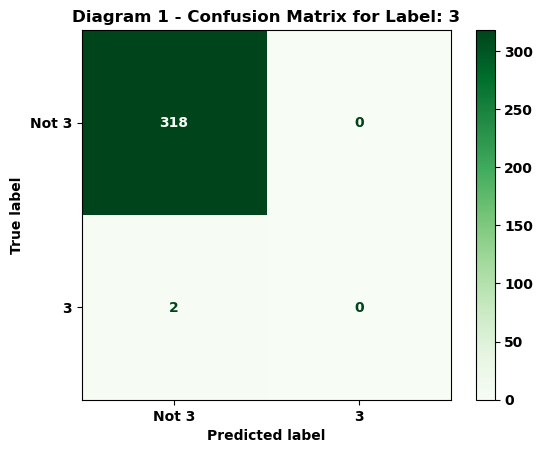

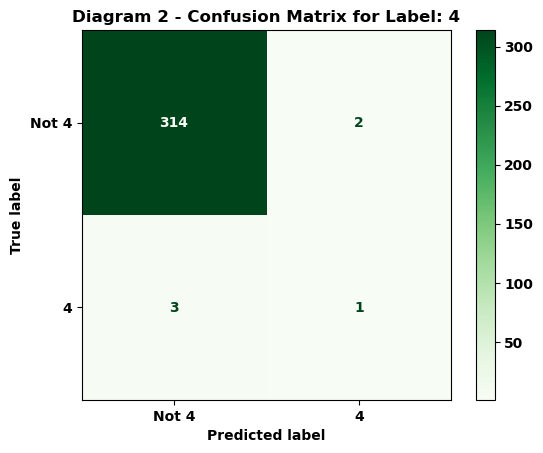

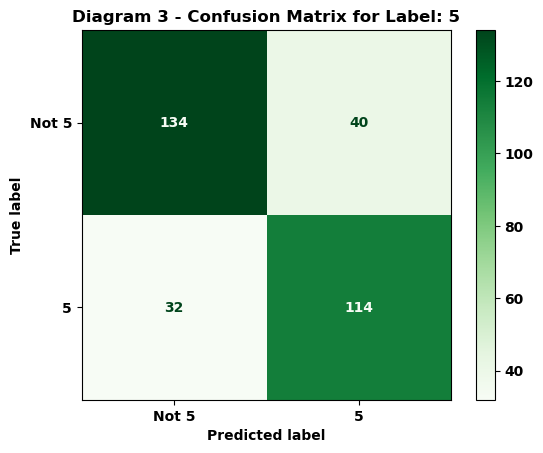

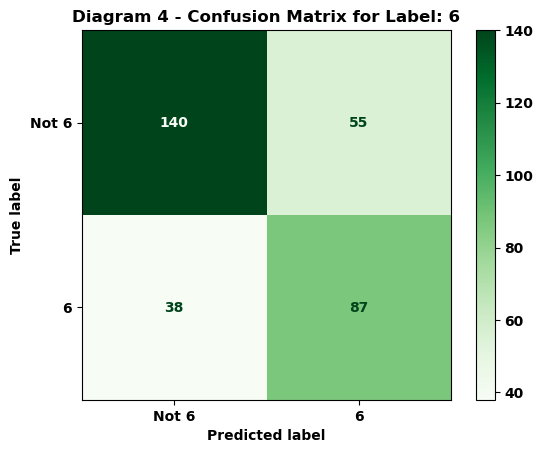

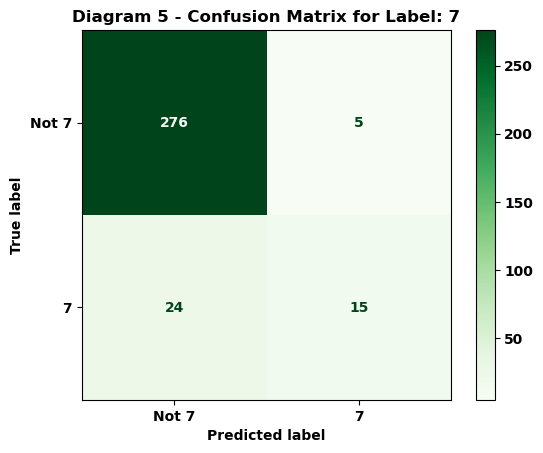

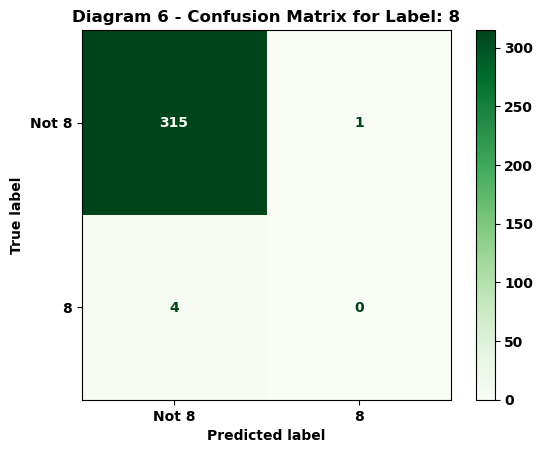

In [39]:
# Multi-class Confusion Matrix
labels = np.unique(y_test)

y_pred = best_model.predict(X_test)
confusion_matrix = multilabel_confusion_matrix(y_test, y_pred, labels = labels)

# Iterate over each label's confusion matrix
for i in range(len(labels)):
    matrix = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix[i], 
                                    display_labels=["Not " + str(labels[i]), labels[i]])
    matrix.plot(cmap='Greens')  # Optional: use a color map to enhance visualization
    plt.title(f"Diagram {i+1} - Confusion Matrix for Label: {labels[i]}")
    plt.show()

In [37]:
columns = ["True Negative", "False Positive", "False Negative", "True Positive"]
 
# Create a DataFrame with proper column names and labels to summarize confusion matrices
conf_matrix_summary_df = pd.DataFrame(confusion_matrix.reshape(len(labels), -1), index=labels, columns=columns).T
conf_matrix_summary_df

,3,4,5,6,7,8
True Negative,318,314,134,140,276,315
False Positive,0,2,40,55,5,1
False Negative,2,3,32,38,24,4
True Positive,0,1,114,87,15,0


_Table 3: Summary of Confusion Matrices_

## Discussion:


summarize what you found

discuss whether this is what you expected to find?

discuss what impact could such findings have?

discuss what future questions could this lead to?

From the process of selecting an appropriate model, 5-fold cross validation was done on each model, using the training data. The validation scores (accuracy) of each model was assessed and the Support Vector Classifier (SVC) with RBF Kernel resulted in the best score. There was a large amountobserved overfitting on the training data with the Decision Tree model. The k-Nearest Neighbours, Naive Bayes and Logistic Regression all yielded similar validation scores, with the Naive Bayes model performing the worst.


Even though the SVC RBF model gave the best accuracy, it also have the longest fit-time and score-time. The impact of this is that predictions on a large number of value could take a long time, and depending on the scenario may not be ideal. In this case, efficiency is not a great concern, but this should be noted for future use. 

An average accuracy of ~0.6 for both testing and validation will bring some issues for future questions. These questions include: 
* Will using a different kernel for the SVC yield greater performance?
* If some features are excluded or more chemical features are added, will performance differ?

## References

Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). Modeling wine preferences by data mining from physicochemical properties. Decision Support Systems, 47(4), 547-553. Retrieved from http://www3.dsi.uminho.pt/pcortez/wine/

UCI Machine Learning Repository. (n.d.). Wine quality dataset. Retrieved from https://archive.ics.uci.edu/dataset/186/wine+quality

Cortez, P., & Cerdeira, A. (2009). Modeling wine preferences by data mining from physicochemical properties. Retrieved from https://www.semanticscholar.org/paper/Modeling-wine-preferences-by-data-mining-from-Cortez-Cerdeira/bf15a0ccc14ac1deb5cea570c870389c16be019c